# ALS on Last.fm 360K (implicit library)

Build a user × artist sparse matrix from the 360K dataset and fit Alternating Least Squares for recommendations.

In [1]:
import sys
from pathlib import Path

# Ensure src is importable (run from project root or notebooks/)
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import implicit

from src.loader import load_360k
from src.split import holdout_per_user, split_matrix
from src.validation import evaluate, ndcg_at_k
from src.eval_als import evaluate_als_dataset

d:\dev\recsysplayground\recsysplaygrounds\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load 360K plays (limit_rows=True → 500k rows; False → full dataset)
plays = load_360k(limit_rows=True)
plays

,user_id,artist_id,artist_name,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706
...,...,...,...,...
499995,074aa6389a7fdcec6fb6024e03f3126a522a9e93,2bf704b3-4c05-441f-ad54-52722c1bdba9,Ленинград,21
499996,074aa6389a7fdcec6fb6024e03f3126a522a9e93,550140e2-dbfd-45ad-8940-99ccaebf8bd5,isabel,20
499997,074aa6389a7fdcec6fb6024e03f3126a522a9e93,18a0d72d-0be0-4196-a340-035163bfae1c,gregorian,17
499998,074aa6389a7fdcec6fb6024e03f3126a522a9e93,d4a1404d-e00c-4bac-b3ba-e3557f6468d6,ace of base,16


## User × artist sparse matrix

Build a CSR matrix: rows = users, columns = artists, values = play counts (confidence for implicit ALS).

In [3]:
# Unique users and artists (preserve order for stable indices)
users_unique = plays["user_id"].unique()
artists_unique = plays["artist_id"].unique()

user_id_to_idx = {uid: i for i, uid in enumerate(users_unique)}
artist_id_to_idx = {aid: i for i, aid in enumerate(artists_unique)}

idx_to_user_id = np.array(users_unique)
idx_to_artist_id = np.array(artists_unique)

n_users = len(users_unique)
n_artists = len(artists_unique)
print(f"Users: {n_users:,}, Artists: {n_artists:,}")

Users: 10,237, Artists: 49,603


In [4]:
# Map to integer indices (360K has one row per user–artist, so no aggregation needed)
rows = plays["user_id"].map(user_id_to_idx).values
cols = plays["artist_id"].map(artist_id_to_idx).values
data = plays["plays"].values.astype(np.float32)

user_artist = csr_matrix(
    (data, (rows, cols)),
    shape=(n_users, n_artists),
    dtype=np.float32,
)

print(f"Shape: {user_artist.shape}, nnz: {user_artist.nnz:,}")
user_artist

Shape: (10237, 49603), nnz: 499,992


<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 499992 stored elements and shape (10237, 49603)>

## Train/validation split (matrix-based)

Split users and artists; fit on **seen users × seen artists**, evaluate on **unseen users × seen artists** and **seen users × unseen artists**.

In [5]:
split = split_matrix(user_artist, user_ratio=0.8, artist_ratio=0.8, random_state=42)
print("Split shapes (train, val_unseen_users, val_unseen_artists, val_cold_start):")
print(split.train.shape, split.val_unseen_users.shape, split.val_unseen_artists.shape, split.val_cold_start.shape)
print("Train nnz:", split.train.nnz)

Split shapes (train, val_unseen_users, val_unseen_artists, val_cold_start):
(8189, 39682) (2048, 39682) (8189, 9921) (2048, 9921)
Train nnz: 323137


## Holdout for evaluation (level 2)

Within each block, hold out a fraction of each user's interactions so we don't leak them into user factors. **Viewable** = input to recommend/recalculate; **y_true** = held-out items we predict.

In [6]:
HOLDOUT_RATIO = 0.2
HOLDOUT_SEED = 42

train_viewable, y_true_train = holdout_per_user(split.train, holdout_ratio=HOLDOUT_RATIO, random_state=HOLDOUT_SEED)
val_unseen_users_viewable, y_true_cold_users = holdout_per_user(split.val_unseen_users, holdout_ratio=HOLDOUT_RATIO, random_state=HOLDOUT_SEED)
val_unseen_artists_viewable, y_true_cold_artists = holdout_per_user(split.val_unseen_artists, holdout_ratio=HOLDOUT_RATIO, random_state=HOLDOUT_SEED)

# Count users with at least one held-out item (for reporting)
n_train_with_held = sum(1 for s in y_true_train if s)
n_cold_users_with_held = sum(1 for s in y_true_cold_users if s)
n_cold_artists_with_held = sum(1 for s in y_true_cold_artists if s)
print(f"Users with ≥1 held-out: train={n_train_with_held}, cold_users={n_cold_users_with_held}, cold_artists={n_cold_artists_with_held}")

Users with ≥1 held-out: train=8186, cold_users=2047, cold_artists=8156


## Hyperparameter tuning: number of iterations

Tune iterations using **NDCG@10 on the training holdout** (viewable → recalc user → recommend; score vs y_true_train). Then fit the final model with the best iteration count and use cold users / cold artists as **test** evaluation.

In [7]:
model = implicit.als.AlternatingLeastSquares(
    factors=128,
    regularization=0.01,
    iterations=50,
    random_state=42,
)
model.fit(split.train, show_progress=True)

d:\dev\recsysplayground\recsysplaygrounds\.env\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 50/50 [00:07<00:00,  7.00it/s]


In [8]:
N_REC = 50
K_VALUES = (5, 10, 20)

metrics_train = evaluate_als_dataset(
    model, train_viewable, y_true_train,
    mode="user", N_REC=N_REC, k_values=K_VALUES,
)

## Test evaluation: cold users (unseen users × seen artists)

Recommend from **train artists** for **val users** using recalculated user factors from **viewable** interactions only. Ground truth = **held-out** items (no leak).

In [9]:
metrics_cold_users = evaluate_als_dataset(
    model, val_unseen_users_viewable, y_true_cold_users,
    mode="user", N_REC=N_REC, k_values=K_VALUES,
)

## Test evaluation: cold artists (seen users × unseen artists)

Recalculate **item factors** for val artists from **viewable** interactions only (items × users); recommend among val artists. Ground truth = **held-out** items (no leak).

In [10]:
metrics_cold_artists = evaluate_als_dataset(
    model, val_unseen_artists_viewable, y_true_cold_artists,
    mode="item", N_REC=N_REC, k_values=K_VALUES,
)

In [16]:
# Summary: half-unseen validation metrics
import pandas as pd
summary1 = pd.DataFrame({
    "train": metrics_train,
    "cold_users": metrics_cold_users,
    "cold_artists": metrics_cold_artists,
})
summary1

,train,cold_users,cold_artists
precision@5,0.066479,0.088911,0.042079
recall@5,0.044434,0.059283,0.140040
ndcg@5,0.069620,0.097853,0.100875
f1@5,0.053266,0.071135,0.064714
map@5,0.023885,0.034906,0.075931
precision@10,0.056181,0.070835,0.033252
recall@10,0.076583,0.094399,0.223435
ndcg@10,0.073669,0.097816,0.130436
f1@10,0.064814,0.080937,0.057888
map@10,0.029742,0.041929,0.087877


100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


  iterations=1 → NDCG@10 (train holdout) = 0.0706


100%|██████████| 5/5 [00:00<00:00,  5.55it/s]


  iterations=5 → NDCG@10 (train holdout) = 0.0913


100%|██████████| 10/10 [00:01<00:00,  7.60it/s]


  iterations=10 → NDCG@10 (train holdout) = 0.0856


100%|██████████| 20/20 [00:02<00:00,  7.31it/s]


  iterations=20 → NDCG@10 (train holdout) = 0.0784


100%|██████████| 30/30 [00:04<00:00,  7.31it/s]


  iterations=30 → NDCG@10 (train holdout) = 0.0753


100%|██████████| 50/50 [00:06<00:00,  7.42it/s]


  iterations=50 → NDCG@10 (train holdout) = 0.0737


100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


  iterations=100 → NDCG@10 (train holdout) = 0.0725
Best iterations: 5


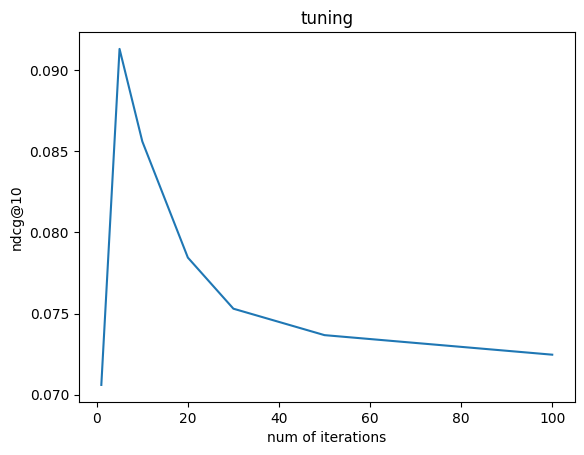

In [12]:
ITERATION_CANDIDATES = [1, 5, 10, 20, 30, 50, 100]
N_REC = 50

from matplotlib import pyplot as plt

results = []
for n_iter in ITERATION_CANDIDATES:
    m = implicit.als.AlternatingLeastSquares(
        factors=128,
        regularization=0.01,
        iterations=n_iter,
        random_state=42,
    )
    m.fit(split.train, show_progress=True)
    rec_ids, _ = m.recommend(
        np.arange(split.train.shape[0]),
        train_viewable,
        N=N_REC,
        filter_already_liked_items=False,
        recalculate_user=True,
    )
    y_pred = [rec_ids[i].tolist() for i in range(rec_ids.shape[0])]
    ndcg = ndcg_at_k(y_true_train, y_pred, k=10)
    results.append((n_iter, ndcg))
    print(f"  iterations={n_iter} → NDCG@10 (train holdout) = {ndcg:.4f}")

best_iterations = max(results, key=lambda x: x[1])[0]
print(f"Best iterations: {best_iterations}")

# plot the ndcg x number of iterations
plt.plot(np.array(results)[:, 0], np.array(results)[:, 1])
plt.title("tuning")
plt.xlabel("num of iterations")
plt.ylabel("ndcg@10")
plt.show()

In [13]:


# Fit final model with best iteration count (for train/cold-users/cold-artists eval below)
model = implicit.als.AlternatingLeastSquares(
    factors=128,
    regularization=0.01,
    iterations=best_iterations,
    random_state=42,
)
model.fit(split.train, show_progress=True)


100%|██████████| 5/5 [00:00<00:00,  5.41it/s]


In [14]:
metrics_cold_artists2 = evaluate_als_dataset(
    model, val_unseen_artists_viewable, y_true_cold_artists,
    mode="item", N_REC=N_REC, k_values=K_VALUES,
)
metrics_cold_users2 = evaluate_als_dataset(
    model, val_unseen_users_viewable, y_true_cold_users,
    mode="user", N_REC=N_REC, k_values=K_VALUES,
)
metrics_train2 = evaluate_als_dataset(
    model, train_viewable, y_true_train,
    mode="user", N_REC=N_REC, k_values=K_VALUES,
)

## Report: all scores (3 datasets)

Summary of metrics on **train holdout**, **test: cold users**, and **test: cold artists**.

In [17]:
report = pd.DataFrame({
    "Train holdout": metrics_train2,
    "Test: cold users": metrics_cold_users2,
    "Test: cold artists": metrics_cold_artists2,
})
# Concatenate report and summary1, adding keys to the columns for MultiIndex
report = pd.concat(
    [report, summary1],
    axis=1,
    keys=['tuned iterations', '50 iterations']
)

report.round(4)

tuned iterations                                      \
                Train holdout Test: cold users Test: cold artists   
precision@5            0.0837           0.0793             0.0379   
recall@5               0.0556           0.0528             0.1270   
ndcg@5                 0.0902           0.0872             0.0906   
f1@5                   0.0668           0.0634             0.0584   
map@5                  0.0317           0.0307             0.0684   
precision@10           0.0670           0.0644             0.0299   
recall@10              0.0907           0.0860             0.2005   
ndcg@10                0.0913           0.0881             0.1168   
f1@10                  0.0771           0.0736             0.0521   
map@10                 0.0386           0.0371             0.0788   
precision@20           0.0599           0.0511             0.0230   
recall@20              0.1647           0.1374             0.3078   
ndcg@20                0.1265           0.1132             0.1468   
f1@20                  0.0878           0.0745             0.0428   
map@20                 0.0475           0.0433             0.0870   
mrr                    0.2275           0.2222             0.1182   

             50 iterations                          
                     train cold_users cold_artists  
precision@5         0.0665     0.0889       0.0421  
recall@5            0.0444     0.0593       0.1400  
ndcg@5              0.0696     0.0979       0.1009  
f1@5                0.0533     0.0711       0.0647  
map@5               0.0239     0.0349       0.0759  
precision@10        0.0562     0.0708       0.0333  
recall@10           0.0766     0.0944       0.2234  
ndcg@10             0.0737     0.0978       0.1304  
f1@10               0.0648     0.0809       0.0579  
map@10              0.0297     0.0419       0.0879  
precision@20        0.0554     0.0565       0.0253  
recall@20           0.1549     0.1514       0.3375  
ndcg@20             0.1105     0.1257       0.1625  
f1@20               0.0816     0.0823       0.0470  
map@20              0.0387     0.0491       0.0968  
mrr                 0.1836     0.2435       0.1328